In [1]:
#Global temperature and glaciation study
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('ggplot')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

Workflow:

1. Get global insolation as a function of latitude and obliquity

2. Get global insolation as a function of eccentricity

3. Get albedo as a function of temperature

4. Get temperature as a function of albedo and insolation

5. Propogate temperature with insolation and albedo [t-1]


## Obliquity

In [2]:
obliq_max = 26.82 #maximum axial tilt in degrees
obliq_min = 21.82 #minimum axial tilt in degrees
average_obliq = (obliq_max+obliq_min)/2

obliq_lam = 40000 #in years
obliq_amp_base = (obliq_max-obliq_min)/2.0
obliq_frequency = 2*np.pi*(1/obliq_lam)

#Over the sinusoidal major cycle of obliquity are numerous other, smaller amplitude, cycles.
#Amplitude of the obliquity is on a sinusoidal variation cycle as well,
amp_amp1 = 0.21
amp_freq1 = 2*np.pi*(1/69000) #in cycles / year

#The amplitude of the sin wave varies over time,creating variability packets within the obliquity
obliq_amp = lambda t: amp_amp1*np.sin(amp_freq1*t)
obliquity = lambda t: (obliq_amp_base+obliq_amp(t))*np.sin(obliq_frequency*t+np.pi/3-10*np.pi/20)+(obliq_max+obliq_min)/2.0

## Eccentricity

In [3]:
# num_years = 1e6
# t = np.linspace(0,num_years,1000)

divisor = 2
same_shift = 0
ecc_lam1 = 413000 #in years
ecc_frequency1 = 2*np.pi*(1/ecc_lam1)
ecc_amp1 = 0.013/divisor
eccentricity1 = lambda t: ecc_amp1*np.sin(ecc_frequency1*t+(20*np.pi/20)-(same_shift*np.pi))

ecc_lam2 = 95000 #in years
ecc_frequency2 = 2*np.pi*(1/ecc_lam2)
ecc_amp2 = 0.025/divisor
eccentricity2 = lambda t: ecc_amp2*np.sin(ecc_frequency2*t+(17*np.pi/20)-(same_shift*np.pi))

ecc_lam3 = 125000 #in years
ecc_frequency3 = 2*np.pi*(1/ecc_lam3)
ecc_amp3 = 0.025/divisor
eccentricity3 = lambda t: ecc_amp3*np.sin(ecc_frequency3*t+(30*np.pi/20)-(same_shift*np.pi))

eccentricity = lambda t: np.abs(eccentricity1(t)+1*eccentricity2(t)+1*eccentricity3(t)+0.032)

# min_ecc = np.min(eccentricity(t))
# average_ecc = np.mean(eccentricity(t))
# max_ecc = np.max(eccentricity(t))

In [34]:
#CONVERTER FUNCTIONS
CtoF = lambda T: (T*(9/5))+32 #converter function: C to F
KtoC = lambda T: T-273.15 #converter function: K to C
KtoF = lambda T: CtoF(KtoC(T)) #convert kelvin to F

global rads
rads = (np.pi/180)#converter: degrees to radians by multiplication

#CONSTANTS
global Ks
global I0
global sigma
Ks = 1366 #average insolation from the star in watts / m^2
I0 = Ks/4.0 #average insolation of earth's upper atmosphere, only around 198 reach Earth's surface
sigma = 5.67e-8 #Steffan Boltzmann constant; Watt / (meter^2 K^4)

#Gamma controls the functional albedo vs. temperature. Higher gamma leads to steeper changes in albedo and temperature.
#A lower value gives a relatively flat curve, physically  meaning that changes in temperature don't change the albedo much--the albedo
#in this scenario is not controlled by a temperature feedback.
gamma_ng = 9 #gamma for non glacial period
gamma_pseudo_g = 2 #weaker glacial period
gamma_g = 0.1 #gamma for usada period, corresponding to a glacial period brought on by ubiquitious dust in the atmosphere

global A_ice
global A_hot
global A_avg
A_ice = 0.65
A_hot = 0.3
A_avg = (A_ice+A_hot)/2#(A_ice+A_hot)/2 #average albedo

In [35]:
#INSOLATION AND TEMPERATURE FUNCTIONS

#Using the approximation by Alice Nadeau and Richard McGehee in their paper on the subject,
#lay out the necessary Legendre polynomials p2-6
p2 = lambda x: (3*(x**2)-1)/2
p4 = lambda x: (35*(x**4)-30*(x**2) + 3)/8
p6 = lambda x: (231*(x**6)-315*(x**4) + 105*(x**2) - 5)/16

#this is the insolation as a function of latitude and obliquity; y is sin of latitude, beta is obliquity in degrees
#how to call: s_approx(latitude_sr,obliquity(t))
def s_approx(y,beta):
    #y should be the sin of latitude
    rads = np.pi/180
    q2 = (-5/8)*p2(np.cos(rads*beta))
    q4 = (-9/64)*p4(np.cos(rads*beta))
    q6 = (-65/1024)*p6(np.cos(rads*beta))
    s = 1+q2*p2(y)+q4*p4(y)+q6*p6(y)
    return s

#from numerous sources, including Nadeau&McGehee, the insolation variation caused by changes in eccentricity is:
ins_ecc = lambda e: 1/np.sqrt(1-e**2) #Insolation factor from eccentricity

#this is the average insolation according to Nadeau and McGehee, taking into account the eccentricity and obliquity.
#Q is insolation due to eccentricity
#s is insolation due to latitude and obliquity
Ibar = lambda Q,s: I0*Q*s

In [37]:
#From SciED UCAR website.
adjust = 34
temp_0D = lambda insolation: 54+((insolation/I0)*Ks*(1-A_avg)/(4*sigma))**(1/4) #gives temperature in K with a zero dimensional approach

#From John Baez blog, UCR
A_T = lambda T,gamma: 1-((1-A_ice)+((1-A_hot)-(1-A_ice))*(1+np.tanh(gamma*rads*(T)))/2) #change the albedo with the temperature; lower temps give higher albedo

#New function
temp_from_insolation = lambda insolation,A: ((insolation/I0)*Ks*(A)/(4*sigma))**(1/4) #gives temperature in K, taking albedo changes due to ice into account
#Old function
#temp_from_insolation = lambda insolation,T,gamma: adjust+((insolation/I0)*Ks*(A_T(T,gamma))/(4*sigma))**(1/4) #gives temperature in K, taking albedo changes due to ice into account

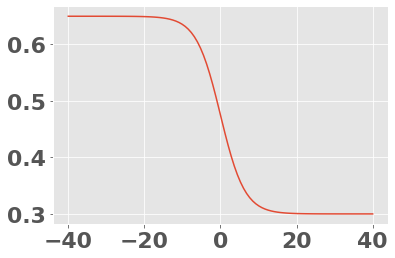

In [43]:
plt.plot(np.linspace(-40,40,100),A_T(np.linspace(-40,40,100),9))

In [38]:
rad_nuinen_meters = 6577389 #radius of nuinen in meters
surface_area_nuinen = 4*np.pi*rad_nuinen_meters**2
latitude_area = lambda lat_f,lat_i,radius: (2*np.pi*radius**2)*(np.sin(lat_f)-np.sin(lat_i))

#AVERAGE TEMPERATURE, CORRECTLY CALCULATED
def global_T(latitude_d,gamma,e,beta,t):
    #Get my latitude in radians
    latitude_r = latitude_d*rads

    #And set up my arrays
    A_a = np.zeros([len(t),len(latitude_d)])
    A_a[0][:] = A_avg
    T_a = np.zeros([len(t),len(latitude_d)])
    T_mean = np.zeros(len(t))

    #Calculate my latitude weights
    latitude_weights = np.zeros(len(latitude_d))
    for i in range(0,len(latitude_d)):
        if i < len(latitude_d)-1:
            percent_weight = (latitude_area(latitude_r[i+1],latitude_r[i],rad_nuinen_meters)/surface_area_nuinen)
        if i == len(latitude_d)-1:
            percent_weight = (latitude_area(rads*90,latitude_r[i],rad_nuinen_meters)/surface_area_nuinen)
        latitude_weights[i] = percent_weight

    plt.plot(latitude_weights)
    #And now get temperature as a function of latitude and time!
    for dt in tqdm(range(0,len(t)-1)):

        #Set up holder array for temperature as a function of latitude
        T_perlat = np.zeros(len(latitude_d))
        for i in range(0,len(latitude_r)):
            
            #Derive albedo at each latitude from temperature at that latititude at previous dt
            if dt != 0:
                A_it = A_T(T_a[dt-1][i],gamma) #Get albedo as a function of both latitude and temperature
                A_a[dt][i] = A_it
            else:
                A_it = A_a[0][0]

            
            T_perlat[i]=KtoC(temp_from_insolation(Ibar(ins_ecc(e[dt]),s_approx(np.sin(latitude_r[i]),beta[dt])),A_it))
        T_a[dt] = T_perlat
        
        T_mean[dt] = np.sum(T_perlat*latitude_weights)
        
    T_mean[-1] = T_mean[-2]
    T_a[-1] = T_a[-2] 
    return T_a,T_mean

100%|██████████| 499/499 [00:08<00:00, 57.29it/s]


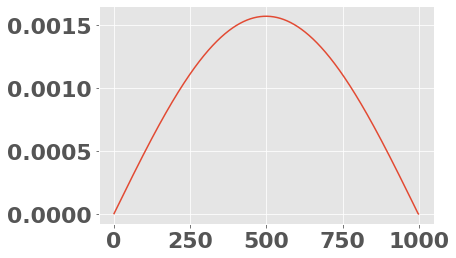

In [94]:
t = np.linspace(0,1e5,500) #Time to model, in years
#Define the latitude space and the sin of the latitude
latitude_d = np.linspace(-90,90,1000)
latitude_sr = np.sin(latitude_d*rads)
gamma = 9

T_a,T_mean = global_T(latitude_d,gamma,eccentricity(t),obliquity(t),t)

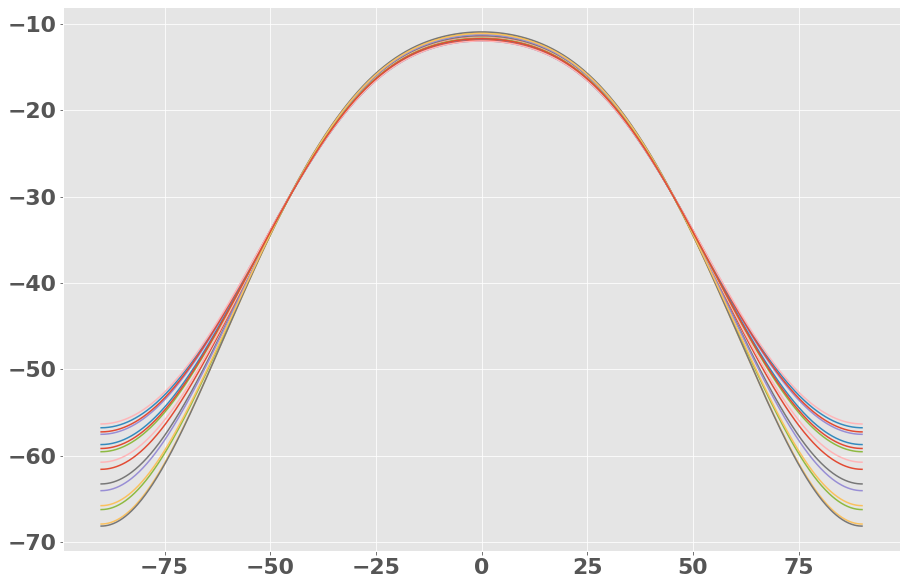

In [95]:
plt.figure(figsize=[15,10])
for year in np.linspace(20,int(len(t))-1,15):
    plt.plot(latitude_d,T_a[int(year)][:])

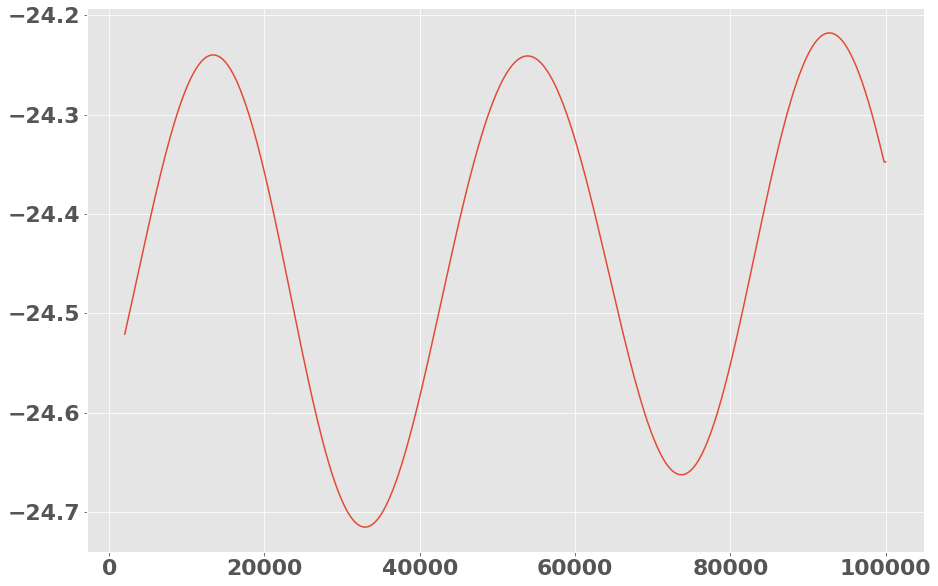

In [98]:
start = 10
plt.figure(figsize=[15,10])
plt.plot(t[start:],T_mean[start:])

In [18]:
def plot_latitude_vs_T(T_a,tchoice=0):
    fig,(ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [1.5, 3]})#plt.figure(figsize=[10,10])
    fig.set_figheight(10)
    fig.set_figwidth(30)
    # plt.subplot(121)
    fig.suptitle("Insolation vs Latitude for time: "+str(tchoice),y=1.05)
    #ax1 = plt.subplot(1,2,1)

    t = np.linspace(0,1e5,int(1e5))
    plot1, = ax1.plot(latitude_d,Ibar(ins_ecc(eccentricity(t[tchoice])),s_approx(latitude_sr,obliquity(t)[tchoice])))
    ax1.set_ylabel("Insolation (W/m^2)")
    ax1.set_xlabel("Latitude (degrees)")
    ax1.set_title("Insolation vs. Latitude")
#    temp = ax1.twinx()
#    temp.spines['right'].set_visible(True)
#    plot4, = temp.plot(latitude_d,T_a[np.where(t==tchoice)[0]])
    
    ob = ax2.twinx()
    # Second, show the right spine.
    ob.spines["right"].set_visible(True)

    plot2, = ax2.plot(t,eccentricity(t), "b-", label="Eccentricity", linewidth='3')
    ax2.yaxis.label.set_color(plot2.get_color())
    ax2.set_ylabel("Eccentricity")
    plot3, = ob.plot(t,obliquity(t), "r-", label="Obliquity (degrees)", linewidth='0.5')
    ob.yaxis.label.set_color(plot3.get_color())
    ob.set_ylabel("Obliquity")

    ax2.axvline(tchoice,color='black',linewidth=3)

    ax2.set_xlabel('Years')
    ax2.set_title('Obliquity and Eccentricity vs Time')

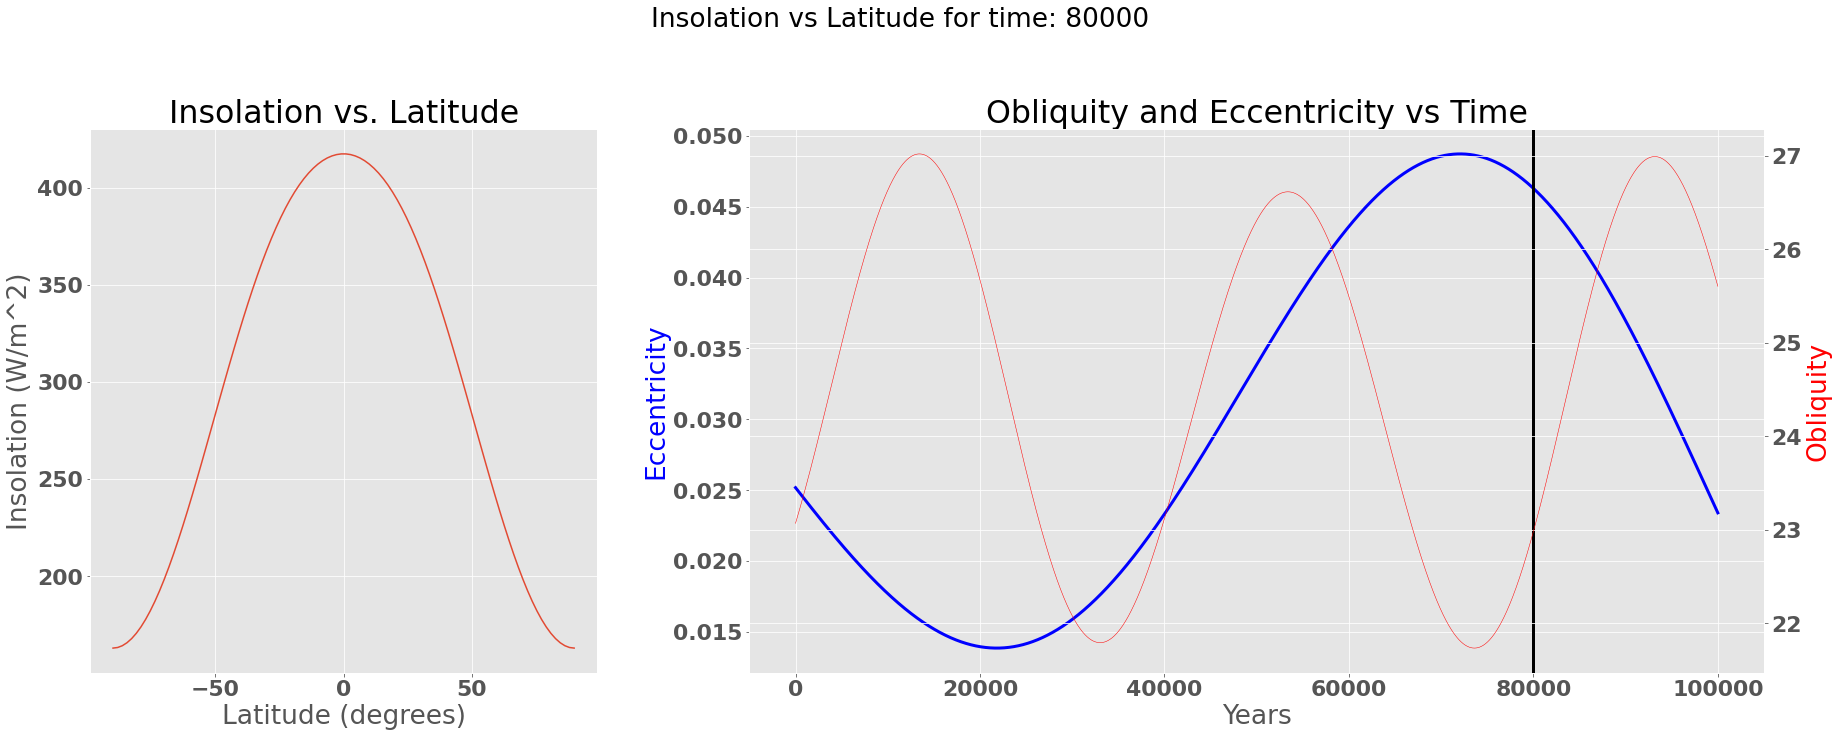

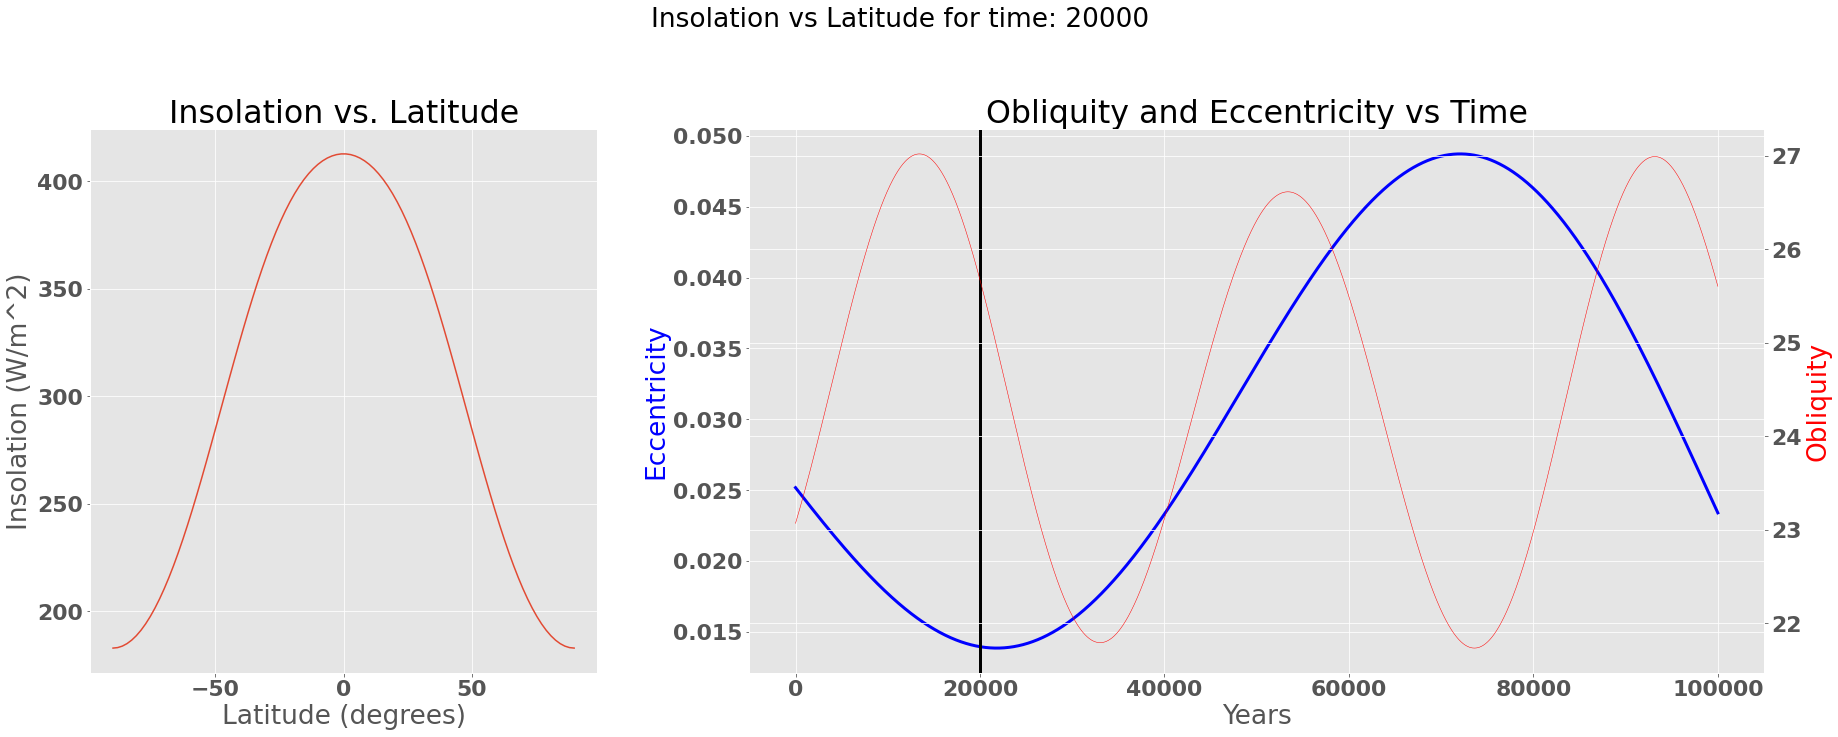

In [19]:
plot_latitude_vs_T(T_a,80000)
plot_latitude_vs_T(T_a,20000)

### Polar temperatures

In [ ]:
def average_polar(gamma,year):
    weighted_temps_poles = []
    surface_area_poles = latitude_area(rads*90,rads*65,rad_nuinen_meters)
    year_index = np.where(t > year)
    
    for i in range(0,ind_of_n65[0][0]):
        T_mean = KtoF(temp_from_insolation(Ibar(t[year_index[0][0]],latitude_r[i]),temp_0D(Ibar(t[year_index[0][0]],latitude_r[i])),gamma))
        if i < 999:
            percent_weight = (latitude_area(latitude_r[i+1],latitude_r[i],rad_nuinen_meters)/surface_area_poles)
        if i == 999:
            percent_weight = (latitude_area(rads*90,latitude_r[i],rad_nuinen_meters)/surface_area_poles)
        weighted_temps_poles.append(T_mean*percent_weight)

    normalized_avg_T_poles = np.sum(weighted_temps_poles)
    return normalized_avg_T_poles